In [1]:
import ase
import matplotlib.pyplot as plt
import numpy as np

import abtem

(walkthrough:frozen_phonons)= 
# Frozen phonons

Thus far we have assumed that the atomic structures from which the electrons scatter are static. However, atoms in real materials are not stationary, but vibrate around their equilibrium position in the crystal due to thermal and zero-point vibrations. 

Vibrational scattering (or electron-phonon scattering) is responsible for features including diffuse backgrounds and [Kikuchi lines](https://en.wikipedia.org/wiki/Kikuchi_lines_(physics)), as well as for a significant part of the high-angle scattering measured in annular dark-field measurements {cite}`hage_phonon_spectroscopy`.

The so-called frozen phonon model is a highly simplified approach to simulate the effects of phonons on electron scattering. Nonetheless, it has been shown to produce essentially the same result as models with a better-justified theoretical foundation from quantum mechanics {cite}`forbes_qep`{cite}`van_dyck_frozen_phonons`. In the frozen phonon approximation, the exit-wave intensity is averaged over several frozen snapshots of the atomic model, emulating distinct vibrational configurations. In practice, each frozen phonon image is created from the equilibrium structure by displacing its atoms by different random offsets.

```{note}
Even though phonon scattering in reality is inelastic, the multislice simulation used with the frozen phonon model is fully elastic same as for the static case. This is an excellent approximation since the energy loss involved with phonon scattering is negligible compared to the primary beam energy.
```

## Kikuchi lines in SrTiO<sub>3</sub> 
As an illustration, we simulate SrTiO<sub>3</sub>$(100)$ with frozen phonons. In order to observe visible Kikuchi lines, the sample needs some thickness, hence the unit cell is repeated 50 times along the $z$-direction. We also need to repeat the atoms in $x$ and $y$ to obtain a statistically significant ensemble.

In [2]:
repetitions = (5, 5, 40)
atoms = ase.io.read("data/srtio3_100.cif") * repetitions

`FrozenPhonons` displaces atoms according to a Gaussian distribution (equivalent to the [Einstein model](https://en.wikipedia.org/wiki/Einstein_solid) of the density of states for phonons) using a random number generator with a given seed (a number to initialize the pseudorandom number generator).

The standard deviation of the Gaussian distribution may be provided as a single number for *all atoms*, as a dictionary for *each element*, or as an array for *each atom*.

Below we create an ensemble of $10$ frozen phonon snapshots, with a standard deviation of atomic displacements of $0.1 \ \mathrm{Å}$ and a seed of $100$. This value of deviation is reasonable if you do not have any better data: it will give more realistic results than not including phonons. 

In [3]:
frozen_phonons = abtem.FrozenPhonons(atoms, num_configs=10, sigmas=0.1, seed=100)

```{warning}
The number of snapshots necessary for a converged simulation depends on the thickness of the sample. Simulations with thin samples may need significantly more snapshots than this example.
```

`FrozenPhonons` can be iterated to obtain the displaced atomic configurations. Below we obtain one of the frozen snapshots.

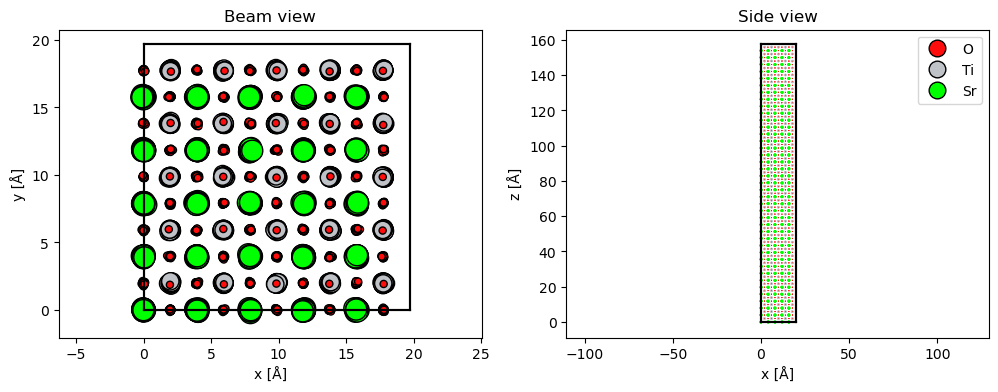

In [4]:
atoms_configuration = next(iter(frozen_phonons))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms_configuration, scale=0.4, ax=ax1, title="Beam view")
abtem.show_atoms(
    atoms_configuration,
    scale=0.4,
    plane="xz",
    legend=True,
    ax=ax2,
    title="Side view",
    linewidth=0.0,
);

`FrozenPhonons` may be used instead of `Atoms` to create a `Potential`.

In [5]:
potential_static = abtem.Potential(atoms, gpts=432, slice_thickness=2)
potential_phonon = abtem.Potential(frozen_phonons, gpts=432, slice_thickness=2)

When we `build` the `Potential`, the resulting `PotentialArray` is 4D: an ensemble of $10$ potentials with slightly displaced atomic configurations, each with $99$ slices on a $512\times512$ grid.

In [6]:
potential_phonon.build().shape

(10, 79, 432, 432)

We run a multislice simulation for a plane wave with an energy of $150 \ \mathrm{keV}$, and then the same simulation with the frozen phonons.

In [7]:
initial_waves = abtem.PlaneWave(energy=150e3)

exit_waves_static = initial_waves.multislice(potential_static).compute()
exit_waves_phonon = initial_waves.multislice(potential_phonon).compute()

[########################################] | 100% Completed | 3.07 ss
[########################################] | 100% Completed | 6.00 ss


The output is an ensemble of 10 exit waves, one for each configuration in the frozen phonon ensemble.

In [8]:
exit_waves_phonon.shape

(10, 432, 432)

We show the intensity of the one of the exit waves and the average intensity of the thermal ensemble. We observe that while the individual snapshots are noisy, this averages out in the thermal ensemble.

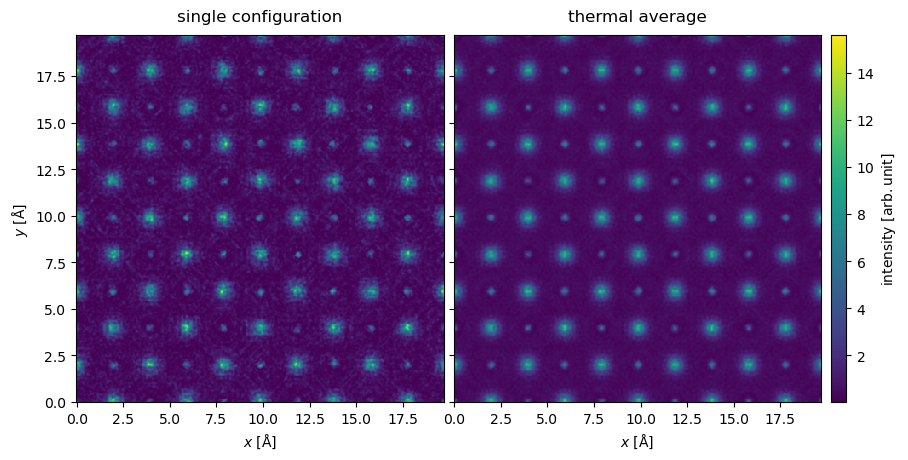

In [9]:
stacked = abtem.stack(
    [exit_waves_phonon[0].intensity(), exit_waves_phonon.intensity().mean(0)],
    ("single configuration", "thermal average"),
)

stacked.show(explode=True, figsize=(10, 6), cbar=True, common_color_scale=True);

Below we compare diffraction patterns for the static model with the model including frozen phonons; the images are shown on a common color scale.

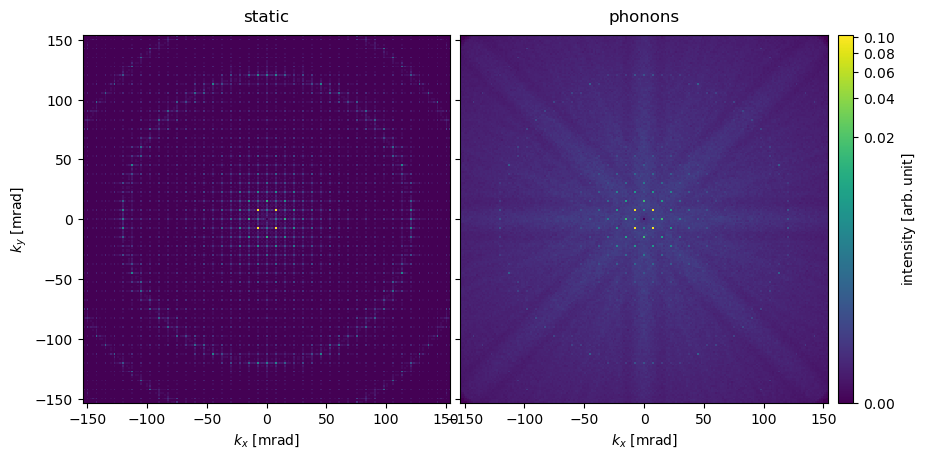

In [10]:
diffraction_patterns_static = exit_waves_static.diffraction_patterns(
    max_angle="valid", block_direct=True
)
diffraction_patterns_phonons = exit_waves_phonon.diffraction_patterns(
    max_angle="valid", block_direct=True
).mean(0)

diffraction_patterns = abtem.stack(
    [
        diffraction_patterns_static,
        diffraction_patterns_phonons,
    ],
    ("static", "phonons"),
)

diffraction_patterns.show(
    explode=True,
    power=0.2,
    units="mrad",
    figsize=(10, 6),
    cbar=True,
    common_color_scale=True,
);

With the frozen phonon ensamble, the higher-order spots are significantly dampened compared to the static model. That intensity is redistributed to a diffuse background with Kikuchi lines that are visible as bands radiating from the center. The Laue diffraction rings (also known as HOLZ lines) visible in the static model are also significantly dampened.

We tabulate the diffraction spots up 3rd order confirming the above observations.

In [11]:
diffraction_patterns.crop(20).index_diffraction_spots(cell=3.945).to_dataframe()

hkl,0 0 0,0 1 0,0 2 0,0 -2 0,0 -1 0,1 0 0,1 1 0,1 2 0,1 -2 0,1 -1 0,...,2 1 0,2 -1 0,-2 0 0,-2 1 0,-2 -1 0,-1 0 0,-1 1 0,-1 2 0,-1 -2 0,-1 -1 0
,,,,,,,,,,,,,,,,,,,,,
static,0.0,0.000875,0.010655,0.010655,0.000875,0.000875,0.101553,0.000245,0.000245,0.101553,...,0.000245,0.000245,0.010655,0.000245,0.000245,0.000875,0.101553,0.000245,0.000245,0.101553
phonons,0.0,0.001529,0.015071,0.015534,0.001253,0.001372,0.097713,0.000017,0.000046,0.097719,...,0.000022,0.000031,0.015089,0.000022,0.000025,0.001399,0.097019,0.000022,0.000049,0.096882


## STEM simulation with frozen phonons

While the intensity of higher-order spots is generally dampened by phonons, this is compensated for by high-angle diffuse scattering. Thus it is not necessarily obvious how phonon scattering affects STEM simulations with a HAADF detector. 

To model this, we create a `Probe` with an energy of $200 \ \mathrm{keV}$ and a convergence semi-angle of $20 \ \mathrm{mrad}$. We make a `LineScan` along the diagonal of a single periodic unit.

In [12]:
probe = abtem.Probe(energy=150e3, semiangle_cutoff=20)

scan = abtem.LineScan(
    start=(0, 0),
    end=(1 / repetitions[0], 1 / repetitions[1]),
    fractional=True,
    potential=potential_static,
    endpoint=False,
)

probe.grid.match(potential_static)

We create a stack of measurements from both models, and `compute`. Note that this calculation will take about a minute: each scan position needs to be simulated for each phonon configuration. 

In [13]:
measurements_static = probe.scan(potential_static, scan=scan).compute()
measurements_phonon = probe.scan(potential_phonon, scan=scan).compute()

[########################################] | 100% Completed | 5.26 sms
[########################################] | 100% Completed | 24.08 ss


In [14]:
measurements = abtem.stack(
    [measurements_static, measurements_phonon], ("static", "phonons")
)

The `FlexibleAnnularDetector` was used by default, hence we can now choose how the result should be integrated.
Below the fully elastic and phonon models are integrated for a BF signal ($[0, 20] \ \mathrm{mrad}$), two MAADF signals ($[50, 100] \ \mathrm{mrad}$ and $[50, 120] \ \mathrm{mrad}$) and HAADF signal ($[80, 200] \ \mathrm{mrad}$). We stack the results to create a single measurement.

In [15]:
stacked = (
    abtem.stack(
        [
            measurements.integrate_radial(inner=0, outer=20),
            measurements.integrate_radial(inner=50, outer=100),
            measurements.integrate_radial(inner=50, outer=120),
            measurements.integrate_radial(inner=80, outer=200),
        ],
        ("[0, 20] mrad", "[50, 100] mrad", "[50, 120] mrad", "[65, 200] mrad"),
    )
    .interpolate(0.1)
    .tile(2)
)

In [16]:
stacked.shape

(4, 2, 112)

We can selectively "explode" the first axis by setting `explode=0` and `overlay=1`.

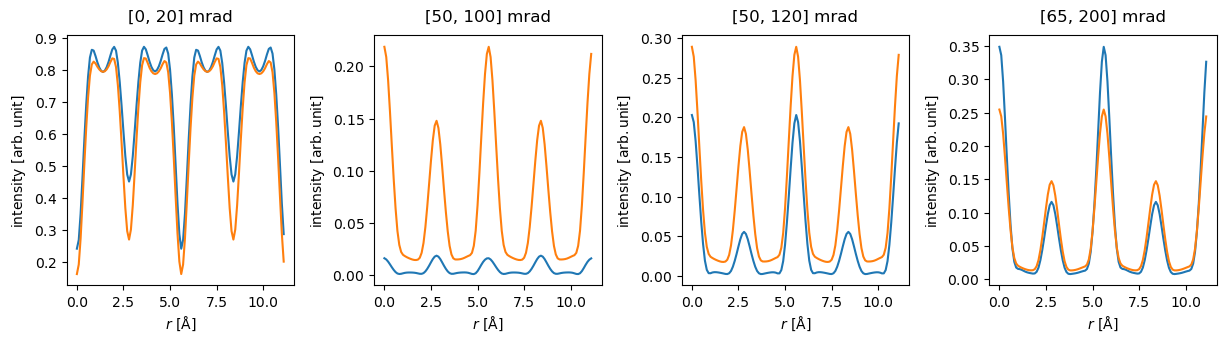

In [17]:
visualization = stacked.show(
    common_scale=False, figsize=(13, 3), explode=0, overlay=1
)

The importance of phonon scattering is clearly demonstrated. The scattering in the phonon model is generally stronger, especially the background, but on a strongly scattering column the static model may sometimes scatter more strongly, as seen in the HAADF signal.

Comparing the MAADF signals in the middle two panels, we see how sensitive the static model is to the inclusion of the first Laue diffraction ring (at $\sim 110 \ \mathrm{mrad}$) in the integration range: increasing the outer angle from $100$ to $120 \ \mathrm{mrad}$ drastically raises the blue curve.  